## **Q.5**

# **Step 1: Read, Load and Combine Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numpy.polynomial.legendre import legval

In [ ]:
def load_dataset(filename='ZipDigits.train'):

    with open(filename) as dataset_file:
        features_list = []
        labels_list = []
        dataset_lines = dataset_file.readlines()
        for data_line in dataset_lines:
            elements = data_line.strip().split(' ')
            label = int(float(elements[0]))
            labels_list.append(label)
            feature_values = [float(value) for value in elements[1:]]
            features_list.append(feature_values)
        features = np.array(features_list)
        targets = np.array(labels_list)
        targets = targets.reshape((targets.shape[0], 1))
        print(f'Features shape: {features.shape}')
        print(f'Targets shape: {targets.shape}')
        return features, targets

In [ ]:
# Load training and test data
Xdigitstrain, ydigitstrain = load_dataset('ZipDigits.train')
Xdigitstest, ydigitstest = load_dataset('ZipDigits.test')

# Adjust labels: +1 for digit 1, -1 for others
ydigitstrain = np.where(ydigitstrain == 1, 1, -1)
ydigitstest = np.where(ydigitstest == 1, 1, -1)

# Combine data
Xcombined = np.concatenate((Xdigitstrain, Xdigitstest), axis=0)
ycombined = np.concatenate((ydigitstrain, ydigitstest), axis=0)

print(f'Combined feature matrix shape: {Xcombined.shape}')
print(f'Combined label vector shape: {ycombined.shape}')

Features shape: (7291, 256)
Targets shape: (7291, 1)
Features shape: (2007, 256)
Targets shape: (2007, 1)
Combined feature matrix shape: (9298, 256)
Combined label vector shape: (9298, 1)


In [ ]:
print("Number of '1' labels in ycombined:", np.sum(ycombined == 1))
print("Number of 'Not 1' labels in ycombined:", np.sum(ycombined == -1))

Number of '1' labels in ycombined: 1269
Number of 'Not 1' labels in ycombined: 8029


# **Step 2: Features Selection**

In [ ]:
def calculateAverageIntensity(pixelData):

    print('Calculating average intensity feature')
    numSamples, numPixels = pixelData.shape
    print(f'Input dimensions {numSamples}, {numPixels}')

    # Compute the average intensity for each image
    avgIntensities = np.mean(pixelData, axis=1, keepdims=True)

    print(f'Output dimensions {avgIntensities.shape}')
    return avgIntensities

def calculateImageSymmetry(pixelData):

    print('Calculating symmetry feature')
    numSamples, numPixels = pixelData.shape
    print(f'Input dimensions {numSamples}, {numPixels}')
    reshapedImages = [pixelData[i, :].reshape((16, 16)) for i in range(numSamples)]
    flippedImages = [np.flip(reshapedImages[i], axis=1) for i in range(numSamples)]

    reshapedImages = np.array(reshapedImages)
    flippedImages = np.array(flippedImages)

    # Compute symmetry by mean squared error between image and its horizontal flip
    mseDifferences = np.mean(np.square(reshapedImages - flippedImages), axis=(1, 2))
    imageSymmetries = 1 / (1 + mseDifferences)

    imageSymmetries = imageSymmetries.reshape(numSamples, 1)
    print(f'Output dimensions {imageSymmetries.shape}')
    return imageSymmetries

def createAugmentedFeatureMatrix(pixelData):

    numSamples, _ = pixelData.shape
    avgIntensity = calculateAverageIntensity(pixelData)
    imgSymmetry = calculateImageSymmetry(pixelData)
    biasColumn = np.ones((numSamples, 1))
    augmentedFeatures = np.concatenate((biasColumn, avgIntensity, imgSymmetry), axis=1)
    print(augmentedFeatures)
    print(f'Dimensions of augmented feature matrix: {augmentedFeatures.shape}')
    return augmentedFeatures

print('Creating augmented feature matrix for training data')

augmentedTrainFeatures = createAugmentedFeatureMatrix(Xcombined)
numAugmentedTrain, featureDimension = augmentedTrainFeatures.shape

Creating augmented feature matrix for training data
Calculating average intensity feature
Input dimensions 9298, 256
Output dimensions (9298, 1)
Calculating symmetry feature
Input dimensions 9298, 256
Output dimensions (9298, 1)
[[ 1.         -0.31781641  0.66843001]
 [ 1.         -0.11173828  0.59007206]
 [ 1.         -0.53799609  0.61461237]
 ...
 [ 1.         -0.38228516  0.48940933]
 [ 1.          0.01994141  0.71588486]
 [ 1.         -0.62204687  0.86770629]]
Dimensions of augmented feature matrix: (9298, 3)


# **Step 3: Normalize Features**

In [ ]:
def normalizeFeatures(features):
    # Exclude the bias column from normalization
    featuresWithoutBias = features[:, 1:]

    minVals = featuresWithoutBias.min(axis=0)
    maxVals = featuresWithoutBias.max(axis=0)
    rangeVals = maxVals - minVals

    # Normalize to [0, 1], then scale to [-1, 1]
    normalizedFeaturesWithoutBias = ((featuresWithoutBias - minVals) / rangeVals) * 2 - 1

    # Re-add the bias column after normalization
    normalizedFeatures = np.concatenate([features[:, :1], normalizedFeaturesWithoutBias], axis=1)
    return normalizedFeatures

# Apply normalization to the augmented feature matrix
normalizedTrainFeatures = normalizeFeatures(augmentedTrainFeatures)  # Assuming augmentedTrainFeatures is your combined dataset

# **Step 3: Create Input and Test Datasets**

In [ ]:
def createDatasets(features, labels, num_samples=300):
    # Find the indices for each class
    plus1s_indices = np.where(labels == 1)[0]
    minus1s_indices = np.where(labels == -1)[0]

    # Shuffle the indices for each class
    np.random.shuffle(plus1s_indices)
    np.random.shuffle(minus1s_indices)

    # Determine the number of samples to take from each class
    num_plus1s = int(num_samples * len(plus1s_indices) / len(labels))
    num_minus1s = num_samples - num_plus1s

    # Select the indices for the training set from each class
    train_indices = np.concatenate((plus1s_indices[:num_plus1s], minus1s_indices[:num_minus1s]))
    np.random.shuffle(train_indices)  # Shuffle the training set indices to mix both classes

    # The remaining indices form the test set
    test_indices = np.concatenate((plus1s_indices[num_plus1s:], minus1s_indices[num_minus1s:]))

    # Split the features and labels into training and test sets using the selected indices
    D_features = features[train_indices, :]
    D_labels = labels[train_indices]
    Dtest_features = features[test_indices, :]
    Dtest_labels = labels[test_indices]

    return D_features, D_labels, Dtest_features, Dtest_labels

In [ ]:
D_features, D_labels, Dtest_features, Dtest_labels = createDatasets(normalizedTrainFeatures, ycombined.flatten())  # Assuming 'normalizedFeatures' and 'ycombined' are correctly defined

# Confirm the balance of classes again
print("Number of '1' labels in D_labels:", np.sum(D_labels == 1))
print("Number of 'Not 1' labels in D_labels:", np.sum(D_labels == -1))

Number of '1' labels in D_labels: 40
Number of 'Not 1' labels in D_labels: 260


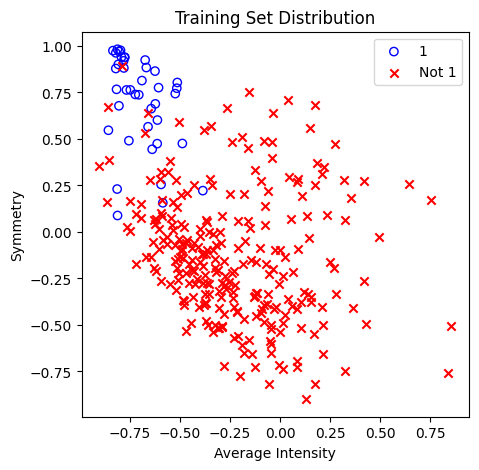

Number of '1' labels in D_labels: 40
Number of 'Not 1' labels in D_labels: 260


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(5, 5))
# For the training dataset
plus1s_train = np.where(D_labels.flatten() == 1)[0]  # Flattening might be necessary if D_labels is a 2D column vector
minus1s_train = np.where(D_labels.flatten() == -1)[0]
Xplus1s_train = D_features[plus1s_train, :]
Xminus1s_train = D_features[minus1s_train, :]

axs.scatter(Xplus1s_train[:, 1], Xplus1s_train[:, 2], marker='o', color='blue', facecolors='none', label='1')
axs.scatter(Xminus1s_train[:, 1], Xminus1s_train[:, 2], marker='x', color='red', label='Not 1')
axs.set_xlabel('Average Intensity')
axs.set_ylabel('Symmetry')
axs.legend()
plt.title('Training Set Distribution')
plt.show()

# Confirm the balance of classes
print("Number of '1' labels in D_labels:", np.sum(D_labels == 1))
print("Number of 'Not 1' labels in D_labels:", np.sum(D_labels == -1))


# **Task 1: 10-th order Polynomial Transform**

In [ ]:
def LegendrePolynomials(x, Q):
    L = np.zeros(Q + 1)
    L[0] = 1  # L_0(x) = 1
    if Q >= 1:
        L[1] = x  # L_1(x) = x

    for k in range(2, Q + 1):
        L[k] = ((2*k - 1)/k) * x * L[k - 1] - ((k - 1)/k) * L[k - 2]

    return L

In [ ]:
def polynomialTransformLegendre(X, Q):
    '''
    Compute the Legendre Polynomial Feature Transform
    Input:
        X: A 2 dimensional N x d numpy array
        Q: The desired degree of polynomial
    Output:
        Z: A 2 dimensional N x d_tilde numpy array
    '''
    N, d = X.shape
    # Initialize Z with bias term and space for polynomial terms
    Z = np.ones((N, 1 + d * Q))

    # Compute Legendre polynomial terms
    for i in range(N):
        L_terms = []
        for j in range(d):
            L_terms.extend(LegendrePolynomials(X[i, j], Q)[1:])  # Exclude the 0th term (constant)
        Z[i, 1:] = np.array(L_terms)

    return Z

In [ ]:
Q = 10
# Apply the transformation
Z = polynomialTransformLegendre(D_features, Q)
print(f'Z shape {Z.shape}')

# Apply the transformation to the test set as well
Ztest = polynomialTransformLegendre(Dtest_features, Q)
print(f'Ztest shape {Ztest.shape}')

Z shape (300, 31)
Ztest shape (8998, 31)


# **Task 2: Overfitting**

In [ ]:
def squaredError(w, X, y):
    predictions = X @ w
    errors = predictions - y
    return np.mean(errors**2)

def linearRegressionRegularized(X, y, lambda_reg):
    N, d = X.shape
    A = X.T @ X
    b = X.T @ y

    if lambda_reg == 0:
        # Use pseudoinverse for lambda = 0 to handle singular matrices
        w_reg = np.linalg.pinv(A) @ b
    else:
        # Add regularization term only to non-bias terms (assuming first column of X is the bias term)
        I = np.eye(d)
        I[0, 0] = 0  # Don't regularize the bias term
        A += lambda_reg * I
        # Solve the regularized normal equations
        w_reg = np.linalg.solve(A, b)

    return w_reg

def plotNonLinearSeparator(w, X, y, Q, title=''):
    # Create a grid for plotting
    x_min, x_max = -1, 1  # Assuming transformed feature values are between -1 and 1 after normalization
    y_min, y_max = -1, 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Flatten the grid for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Apply the same polynomial transformation to the grid points
    grid_Z = polynomialTransformLegendre(np.hstack((np.ones((grid.shape[0], 1)), grid)), Q)

    # Predict using the trained model
    Z_vals = grid_Z.dot(w)
    Z_vals = Z_vals.reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z_vals, levels=[-float('inf'), 0, float('inf')], cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[y == 1, 1], X[y == 1, 2], c='blue', label='1')
    plt.scatter(X[y == -1, 1], X[y == -1, 2], c='red', label='Not 1')
    plt.legend()
    plt.xlabel('Average Intensity')
    plt.ylabel('Symmetry')
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1355: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


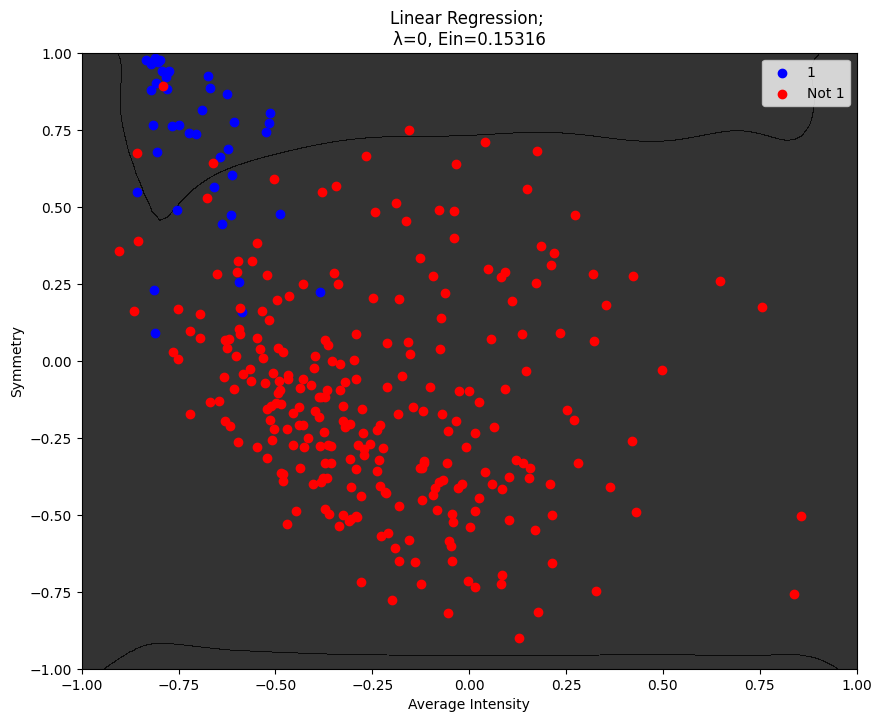

In [ ]:
lambda_reg = 0
w_reg = linearRegressionRegularized(Z, D_labels, lambda_reg)

Ein = np.round(squaredError(w_reg, Z, D_labels), 5)

# Make sure to define the plotting function or use the provided code for it
plotNonLinearSeparator(w_reg, D_features, D_labels, Q=10, title=f'Linear Regression; \nλ={lambda_reg}, Ein={Ein}')

The fact that regularization is not applied (λ = 0), along with the complexity of a 10th order polynomial feature transformation, it is likely that the model is **Overfitting**. Overfitting is characterized by a model that fits the training data too closely, capturing noise and outliers in addition to the underlying data pattern.

If the decision boundary on the plot is very intricate and appears to be contorting to pass through or around individual data points, rather than capturing the general trend of the data, this is a strong indication of overfitting.

# **Task 3: Regularization**

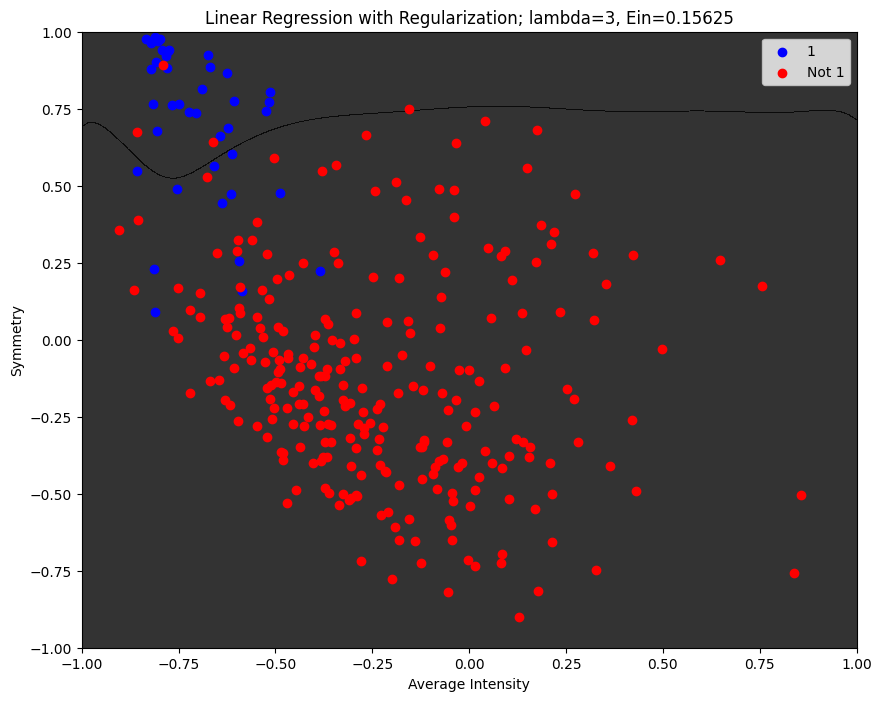

In [ ]:
# Apply regularization with lambda = 3
lambda_reg = 3
w_reg = linearRegressionRegularized(Z, D_labels, lambda_reg)

Ein = np.round(squaredError(w_reg, Z, D_labels), 5)

# Plot the decision boundary for the regularized model
plotNonLinearSeparator(w_reg, D_features, D_labels, Q=10, title=f'Linear Regression with Regularization; lambda={lambda_reg}, Ein={Ein}')

A few observations should be made in light of the decision boundary in the figure with regularization parameter λ=3:

Complexity of Decision border: Compared to an unregularized model, the decision border appears to have smoothed out, which would suggest that regularization is having an effect on reducing overfitting.

match to Data: The boundary is not overfitting since it does not match all of the data points, especially the blue ones.

Data Separation: Without seeming unduly simplistic, the decision boundary offers a fair division between the classes. Given that it is not too far from the red points, underfitting is also unlikely to be happening.

Error Rate: The plot's title includes the in-sample error Ein. A low error value that is in close proximity to the test or cross-validation error indicates that the model is fitting well but not overfitting.

Based on these findings, we may infer that the model with λ=3 does not exhibit significant overfitting symptoms because the decision boundary is not unduly complicated. Additionally, since the decision boundary represents the overall pattern in the data, there are no indications of underfitting. The model's capacity to generalize from training data to unobserved data appears to be enhanced by this regularization, which appears to offer a decent compromise between bias and variance.


# **Task 4: Cross Validation**

In [ ]:
from sklearn.model_selection import train_test_split
Z_train, Z_test, D_labels_train, D_labels_test = train_test_split(Z, D_labels, test_size=0.2, random_state=42)

def linearRegressionCVError(X, y, lamda):
    N, d = X.shape
    Ecv = 0
    weights = []
    for n in range(N):
        # Define the training set excluding the nth data point
        X_train = np.delete(X, n, axis=0)
        y_train = np.delete(y, n)  # Corrected for 1D y array

        # Define the validation data point
        X_val = X[n:n+1, :]  # Use slicing to keep a 2D array structure
        y_val = y[n:n+1] if y.ndim > 1 else y[n]  # Adjusted for 1D or 2D y array

        # Ensure y_val is two-dimensional
        y_val = np.array(y_val, ndmin=2)

        # Train the model using the reduced training set
        w_reg = linearRegressionRegularized(X_train, y_train, lamda)

        # Compute the squared error on the validation data point
        val_error = squaredError(w_reg, X_val, y_val)

        # Accumulate the validation error
        Ecv += val_error

        # Save the weights
        weights.append(w_reg)

    # Calculate the average cross-validation error
    Ecv /= N

    # Return both the average cross-validation error and the list of weights
    return Ecv, weights

Lambda	Ecv		Etest
0	0.17550	0.25037
0.01	0.16863	0.24159
0.1	0.16735	0.24372
1	0.16470	0.24379
5	0.16189	0.24287
10	0.16411	0.25254
25	0.17887	0.29799
50	0.20502	0.37264
75	0.22659	0.43271
100	0.24379	0.48007


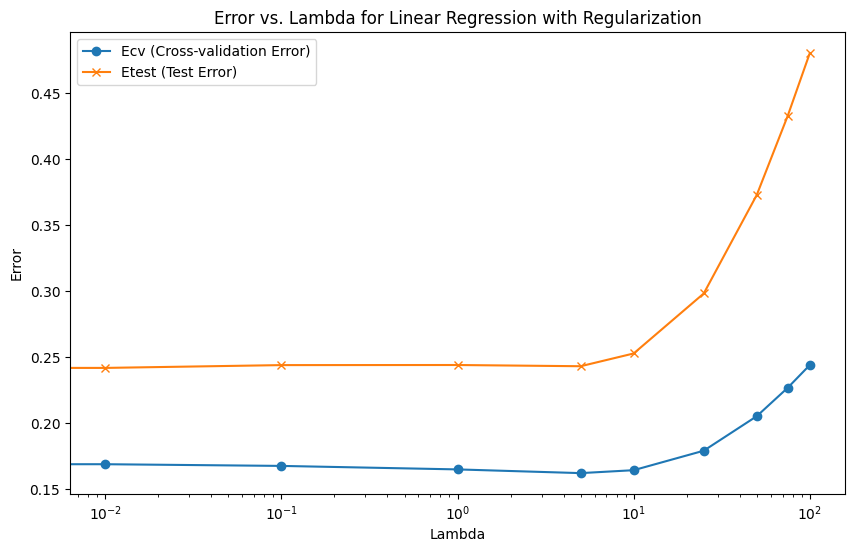

In [ ]:
# Placeholder for the errors
Ecv_values = []
Etest_values = []

# Assuming Z_train and D_labels_train are used for cross-validation
# Assuming Z_test and D_labels_test are used for the final test error evaluation
lambda_values = [0, 0.01, 0.1, 1, 5, 10, 25, 50, 75, 100]

# Calculate errors for each lambda
for lamda in lambda_values:
    Ecv, weights = linearRegressionCVError(Z_train, D_labels_train, lamda)
    Ecv_values.append(Ecv)

    # Use the average of weights for test error calculation
    avg_w = np.mean(weights, axis=0)
    Etest = squaredError(avg_w, Z_test, D_labels_test)
    Etest_values.append(Etest)

print("Lambda\tEcv\t\tEtest")
for lamda, ecv, etest in zip(lambda_values, Ecv_values, Etest_values):
    print(f"{lamda}\t{ecv:.5f}\t{etest:.5f}")

# Plotting Ecv and Etest versus lambda
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, Ecv_values, marker='o', label='Ecv (Cross-validation Error)')
plt.plot(lambda_values, Etest_values, marker='x', label='Etest (Test Error)')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.xscale('log')
plt.title('Error vs. Lambda for Linear Regression with Regularization')
plt.legend()
plt.show()

Ecv and Etest are low for small values of λ (nearing 0), suggesting that the model fits the training data effectively without overfitting. This is probably because the model is perfectly complex, or it might be that, if Ecv and Etest were larger, the model is underfitting.

Ecv begins to rise as λ grows, indicating that the model is becoming less able to accurately represent the underlying pattern in the data due to bias introduced by excessive regularization (over-regularization leading to underfitting).

Ecv and Etest both rise noticeably at high λ levels. This is an obvious indication of underfitting, a condition in which high regularization unnecessarily penalizes the model's weights because the model is too simple to represent the complexity of the data.

This plot suggests that there is an ideal range of λ where the error is minimized before over-regularization causes it to start growing. The objective of regularization is to locate the λ sweet spot, which appears to be toward the lower end of the λ values based on the plot and balances bias and variance.


# **Task 5: Pick λ**

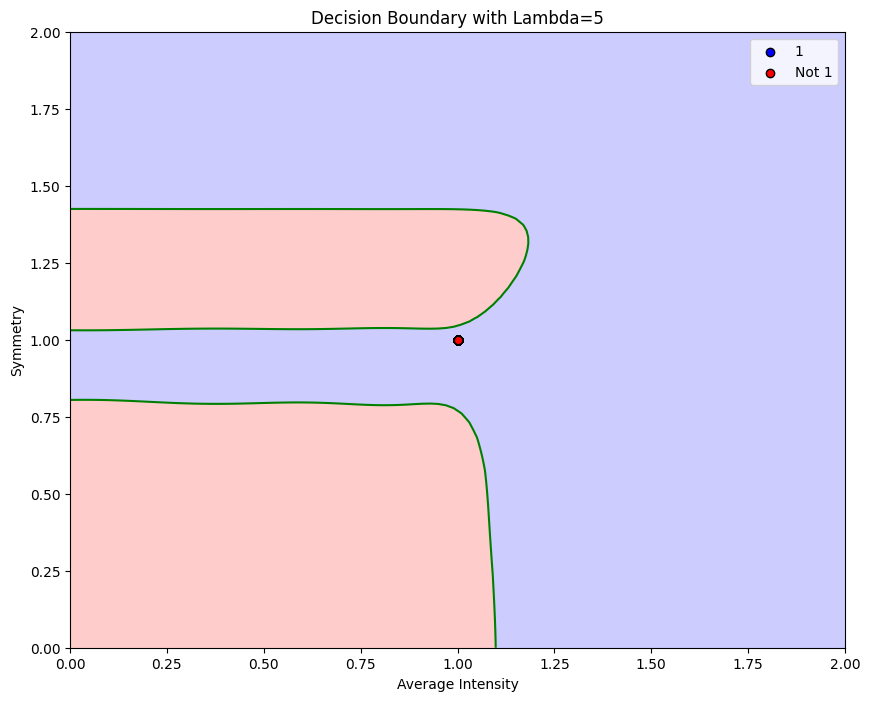

In [ ]:
def plotDecisionBoundary(weights, X, y, lamda, Q):
    # Assuming X's first column is all ones for the intercept.
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Flatten the grid to run it through the polynomial transform
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_transformed = polynomialTransformLegendre(np.hstack((np.ones((grid.shape[0], 1)), grid)), Q)

    # Predict the function values from the features
    preds = np.dot(grid_transformed, weights).reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, preds, levels=[-float('inf'), 0, float('inf')], colors=['red', 'blue'], alpha=0.2)
    plt.contour(xx, yy, preds, levels=[0], colors='green')

    # Scatter plot of actual labels
    plt.scatter(X[y == 1, 1], X[y == 1, 2], c='blue', edgecolor='k', label='1')
    plt.scatter(X[y == -1, 1], X[y == -1, 2], c='red', edgecolor='k', label='Not 1')
    plt.legend()
    plt.title(f'Decision Boundary with Lambda={lamda}')
    plt.xlabel('Average Intensity')
    plt.ylabel('Symmetry')
    plt.show()

# Select lambda_star based on the minimum Ecv value
lambda_star_index = np.argmin(Ecv_values)
lambda_star = lambda_values[lambda_star_index]

# Train the model with lambda_star
weights_star = linearRegressionRegularized(Z_train, D_labels_train, lambda_star)

# Plot the decision boundary
plotDecisionBoundary(weights_star, Z_train, D_labels_train, lambda_star, Q=10)  # Ensure Q is the same as used in training


# **Task 6: Estimate Classification Error**

In [ ]:
from scipy.stats import norm

def calculate_classification_error(w, X, y):
    # Transform the predictions based on the sign (1 or -1)
    predictions = np.sign(X.dot(w))
    # Calculate the classification error
    errors = predictions != y
    error_rate = np.mean(errors)
    return error_rate, errors

# Calculate classification error on test set
error_rate_test, errors_test = calculate_classification_error(weights_star, Z_test, D_labels_test)

# Calculate the 99% confidence interval for the classification error
z_score = norm.ppf(0.995)  # Two-tailed test
margin_error = z_score * np.sqrt((error_rate_test * (1 - error_rate_test)) / len(D_labels_test))

# Ensure the confidence interval is within [0, 1]
confidence_lower = max(0, error_rate_test - margin_error)
confidence_upper = min(1, error_rate_test + margin_error)

# Print the classification error and the 99% confidence interval
print(f"Classification error on test set (Eout(g)): {error_rate_test}")
print(f"99% confidence interval for classification error: [{confidence_lower}, {confidence_upper}]")


Classification error on test set (Eout(g)): 0.08333333333333333
99% confidence interval for classification error: [0, 0.17524201801951844]
